In [1]:
import tensorflow as tf
import numpy as np
from keras import datasets, layers, models
import matplotlib.pyplot as plt

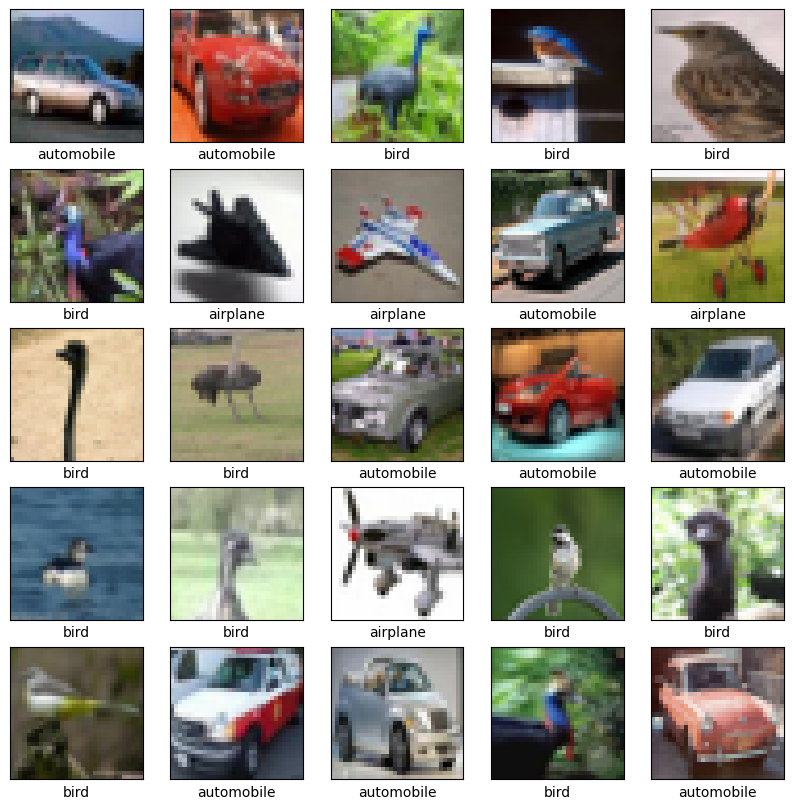

In [2]:
# Load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Define the selected classes
selected_classes = ['airplane', 'automobile', 'bird']

# Find indices of selected classes in CIFAR-10 classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
selected_indices = [class_names.index(class_name) for class_name in selected_classes]

# Filter the dataset to include only the selected classes
train_mask = [label[0] in selected_indices for label in train_labels]
test_mask = [label[0] in selected_indices for label in test_labels]

train_images = train_images[train_mask]
train_labels = train_labels[train_mask]

test_images = test_images[test_mask]
test_labels = test_labels[test_mask]

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Display sample images
plt.figure(figsize=(10, 10))
image_count = 1

for i in range(len(train_labels)):
    plt.subplot(5, 5, image_count)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])

    # Map CIFAR-10 label to the selected class index
    label_index = selected_indices.index(train_labels[i][0])
    plt.xlabel(selected_classes[label_index])

    image_count += 1

    if image_count > 25:  # Display only 25 images
        break

plt.show()


### Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument `input_shape` to your first layer.


In [3]:
# model = tf.keras.models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Let's display the architecture of your model so far:

In [4]:
#model.summary()

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically,  as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

### Add Dense layers on top

To complete the model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D,  then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs.

In [5]:
# model.add(layers.Flatten())
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(10))

Here's the complete architecture of your model:

In [6]:
#model.summary()

The network summary shows that (4, 4, 64) outputs were flattened into vectors of shape (1024) before going through two Dense layers.

### Compile and train the model

In [7]:
from keras.models import Sequential
from keras.layers import Input, Conv2D, Flatten, Dense, MaxPooling2D, GlobalAveragePooling2D

input_layer = Input(shape=(32, 32, 3))
model = Sequential(
  [
    Input(shape=(32, 32, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    # Flatten(),
    # Dense(64, activation='relu'),
    GlobalAveragePooling2D(),
    Dense(3)
  ]
)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,515 (220.76 KB)

 Trainable params: 56,515 (220.76 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Load the pre-trained model or train it
try:
    model = tf.keras.models.load_model('odel/cnn.h5')
except:
    history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
    test_f1 = 2 * (test_acc * test_acc) / (test_acc + test_acc)
    print(f'Test accuracy: {test_acc}')
    print(f'Test f1 macro: {test_f1}')

    # Save the trained model
    model.save('model/cifar_cnn_gap.h5')

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.5898 - loss: 0.8734 - val_accuracy: 0.7400 - val_loss: 0.6012
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7693 - loss: 0.5705 - val_accuracy: 0.8040 - val_loss: 0.5021
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8005 - loss: 0.5009 - val_accuracy: 0.7967 - val_loss: 0.5005
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8152 - loss: 0.4684 - val_accuracy: 0.8273 - val_loss: 0.4326
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8312 - loss: 0.4274 - val_accuracy: 0.8490 - val_loss: 0.4031
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8440 - loss: 0.3953 - val_accuracy: 0.8477 - val_loss: 0.3829
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8490 - loss: 0.3791 - val_accuracy: 0.8497 - val_loss: 0.4043
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8603 - loss: 0.3642 - val_accu

Test accuracy: 0.8610000014305115
Test f1 macro: 0.8610000014305115


In [9]:
for layer in model.layers:
    print(layer.name)


conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
conv2d_2
global_average_pooling2d
dense


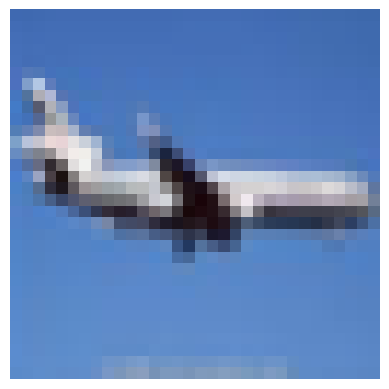

Probability that the given image is 8 : 6.436855316162109


In [10]:
#positive class at 61
image = test_images[61]

# Plot the image
plt.imshow(image)
plt.axis('off')
plt.show()

# Make the model predict on the image
prediction = model.predict(image.reshape(1, 32, 32, 3), verbose=0)
print(f'Probability that the given image is 8 : {prediction[0][0]}')

In [11]:
from keras.models import Model

def get_submodel(model, layer_name):
  return Model(inputs=model.inputs, outputs=model.get_layer(layer_name).output)

# Reshape the image to match the model's input shape
reshaped_image = image.reshape((1,) + tuple(model.input_shape[1:]))

# Getting the output of the last convolutional layer (assuming last layer is convolutional)
weights_FC = model.layers[-1].get_weights()[0]

# Getting the penultimate layer (second-to-last)
model_penultimate = get_submodel(model, model.layers[-2].name)
print("layer name: ", model_penultimate.layers[-2].name)  # Access name of the last layer in submodel

# Predict activations of the penultimate layer
activations_penultimate = model_penultimate.predict(reshaped_image)

# Display the output of the penultimate layer
print(list(zip(range(activations_penultimate.shape[-1]), activations_penultimate[0])))


layer name:  conv2d_2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
[(0, 0.0), (1, 0.0), (2, 1.6919742), (3, 0.77363235), (4, 0.039010093), (5, 0.0), (6, 0.0), (7, 1.1837901), (8, 0.43818885), (9, 0.0), (10, 1.3206587), (11, 0.0), (12, 0.0), (13, 0.8440747), (14, 2.1756308), (15, 0.88519895), (16, 1.2541004), (17, 0.0), (18, 1.7316498), (19, 0.0), (20, 1.5630634), (21, 1.0105214), (22, 0.60058916), (23, 0.6252603), (24, 0.0), (25, 0.0), (26, 1.6378378), (27, 1.6231709), (28, 0.0), (29, 0.87874985), (30, 0.2550615), (31, 0.07960275), (32, 0.0), (33, 0.0), (34, 1.5965469), (35, 1.1142869), (36, 1.5137833), (37, 1.134213), (38, 0.7359205), (39, 0.0), (40, 2.0159686), (41, 0.3286166), (42, 1.1369948), (43, 2.1354055), (44, 0.852437), (45, 0.8004271), (46, 0.0), (47, 0.11561183), (48, 0.0), (49, 0.8552091), (50, 1.1408924), (51, 0.83851516), (52, 0.3408631), (53, 0.8001124), (54, 0.0), (55, 1.9521642), (56, 0.0), (57, 0.46185306), (58, 0.0), (59, 0.0), (60, 0.60103214), (61, 1.735219), (62, 0.0), 

In [12]:
from keras.models import Model
from keras.applications.vgg16 import preprocess_input

def grad_cam(model, img_array, layer_name):
    grad_model = Model(inputs=model.inputs, outputs=model.get_layer(layer_name).output)

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idxs_sorted = np.argsort(predictions[0])[::-1]
        top_class_idx = class_idxs_sorted[0]
        loss = predictions[:, top_class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_output = conv_outputs[0]

    # Resize conv_output to match the spatial dimensions of pooled_grads
    conv_output_resized = tf.image.resize(conv_output, (6,6))

    heatmap = tf.reduce_mean(tf.multiply(conv_output_resized, tf.expand_dims(pooled_grads, axis=0)), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap)

    return heatmap.numpy()

In [13]:
from keras.models import Model
import tensorflow as tf
import numpy as np

def grad_cam_single_neuron(model, img_array, layer_name, neuron_index):

    grad_model = Model(
    inputs=model.inputs,
    outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idxs_sorted = np.argsort(predictions[0])[::-1]
        top_class_idx = class_idxs_sorted[0]
        loss = predictions[:, top_class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_output = conv_outputs[0]
    conv_output_resized = tf.image.resize(conv_output, (6, 6))

    # Select the single neuron for pooling
    selected_neuron_output = tf.expand_dims(conv_output_resized[:, :, neuron_index], axis=-1)
    selected_pooled_grad = tf.expand_dims(pooled_grads[neuron_index], axis=0)

    # Compute Grad-CAM
    heatmap = tf.reduce_mean(tf.multiply(selected_neuron_output, selected_pooled_grad), axis=-1)
    heatmap = tf.nn.relu(heatmap)  # Added ReLU activation
    heatmap /= tf.reduce_max(heatmap)

    return heatmap.numpy()


In [14]:
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras


last_layer = "global_average_pooling2d"
image = test_images[61]


def get_img_array(img):


    array = keras.utils.img_to_array(img)
    ## We add a dimension to transform our array into a "batch"
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, global_average_pooling_layer_name, pred_index=None):
    # Create a sub-model to get the output of the global average pooling layer and the final prediction
    grad_model = tf.keras.Model(
        [model.inputs], [model.get_layer(global_average_pooling_layer_name).output, model.output]
    )

    # Use GradientTape to record the gradient of the predicted class with respect to the output feature map
    with tf.GradientTape() as tape:
        # Get the output of the global average pooling layer and the prediction
        global_average_pooling_output, preds = grad_model(img_array)

        # If pred_index is not provided, select the index with the highest prediction score
        if pred_index is None:
            pred_index = tf.argmax(preds, axis=1)
            pred_index = pred_index.numpy()[0]

        # Get the prediction score for the predicted class
        class_score = preds[0, pred_index]

    # Calculate the gradient of the predicted class score with respect to the output of the global average pooling layer
    grads = tape.gradient(class_score, global_average_pooling_output)

    # Initialize an empty list to store the heatmaps for each neuron
    heatmaps = []

    # Iterate over each neuron in the global average pooling layer
    for neuron_index in range(global_average_pooling_output.shape[-1]):
        # Calculate the gradient importance for the current neuron
        pooled_grads = grads[:, neuron_index]

        # Multiply each channel in the global average pooling output by its corresponding gradient importance
        weighted_global_average_pooling_output = tf.reduce_sum(global_average_pooling_output * tf.expand_dims(pooled_grads, axis=-1), axis=-1)

        # Apply ReLU to the weighted sum
        heatmap = tf.nn.relu(weighted_global_average_pooling_output)

        # Append the heatmap for the current neuron to the list
        heatmaps.append(heatmap.numpy())

    return heatmaps[0]

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def visualize_activations(model, layer_name, images, images_per_row=8, threshold=0.1):
    # Retrieve the layer by name from the model
    layer = model.get_layer(layer_name)

    # Create a sub-model that outputs activations of the specified layer
    activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer.output)
    activations = activation_model.predict(np.expand_dims(images, axis=0))

    # Process activations for visualization
    n_features = activations.shape[-1]
    size = activations.shape[1]
    n_cols = (n_features + images_per_row - 1) // images_per_row

    mat = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):
        for row in range(images_per_row):
            if col * images_per_row + row < n_features:
                channel_image = activations[0, :, :, col * images_per_row + row]

                # Check if the standard deviation of the channel image is greater than the threshold
                if np.std(channel_image) > threshold:
                    # Normalize the channel image for visualization
                    channel_image -= channel_image.mean()
                    channel_image /= (channel_image.std() + 1e-5)  # Add a small value to avoid division by zero
                    channel_image *= 64
                    channel_image += 128
                    channel_image = np.clip(channel_image, 0, 255).astype('uint8')

                    mat[col * size: (col + 1) * size, row * size: (row + 1) * size] = channel_image

    # Determine the number of non-blank feature maps
    num_non_blank = np.sum([np.std(activations[0, :, :, i]) > threshold for i in range(n_features)])

    scale = 1. / size
    plt.figure(figsize=(scale * mat.shape[1], scale * mat.shape[0]))
    plt.title(f"{layer_name} (Non-blank maps: {num_non_blank})")
    plt.grid(False)

    # Plot the visualizations with gaps between subplots
    plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99, wspace=10, hspace=10)
    plt.imshow(mat, aspect='auto', cmap='viridis')
    plt.show()

# Example usage:
# visualize_activations(model, 'conv2d_layer_name', images, threshold=0.1)



In [16]:
from keras import layers

class FixedActivation(layers.Layer):
  """Custom layer to set a specific neuron's activation to 1 and others to 0."""

  def __init__(self, neuron_index, **kwargs):
    super(FixedActivation, self).__init__(**kwargs)
    self.neuron_index = neuron_index

  def call(self, inputs):
    # Extract the desired neuron activation
    activation = inputs[:, self.neuron_index]

    # Create a mask with 1 for the target neuron and 0 for others
    mask = tf.one_hot(self.neuron_index, inputs.shape[1])

    # Apply the mask to zero out other activations
    masked_output = activation * mask

    return masked_output


In [17]:
def analyze_neuron_influence(model, layer_name, neuron_index, class_index, input_data):

  # Get layer by name
  layer = model.get_layer(layer_name)

  # Create the submodel starting from the specified layer
  submodel = tf.keras.Model(inputs=layer.input, outputs=model.output)

  # Create the FixedActivation layer
  fixed_activation = FixedActivation(neuron_index)

  # Insert the FixedActivation layer before the submodel's output
  submodel.layers.insert(-1, fixed_activation)

  # Compile the submodel (assuming it has a classification output layer)
  submodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  # Make predictions with the submodel using your actual input
  predictions = submodel.predict(input_data.reshape(1, 32, 32, 3), verbose=0)

  # Analyze influence on the class (assuming one-hot encoded predictions)
  class_prediction = predictions[0, class_index]
  print(f"Layer: {layer_name}, Neuron: {neuron_index}")
  print(f"Influence on Class {class_index}: {class_prediction:.4f}")

input_data = test_images[61]  # Replace with your actual data
analyze_neuron_influence(model, 'conv2d', 3, 1, input_data)


ValueError: The layer sequential has never been called and thus has no defined output.

1/1 [==============================] - 0s 230ms/step


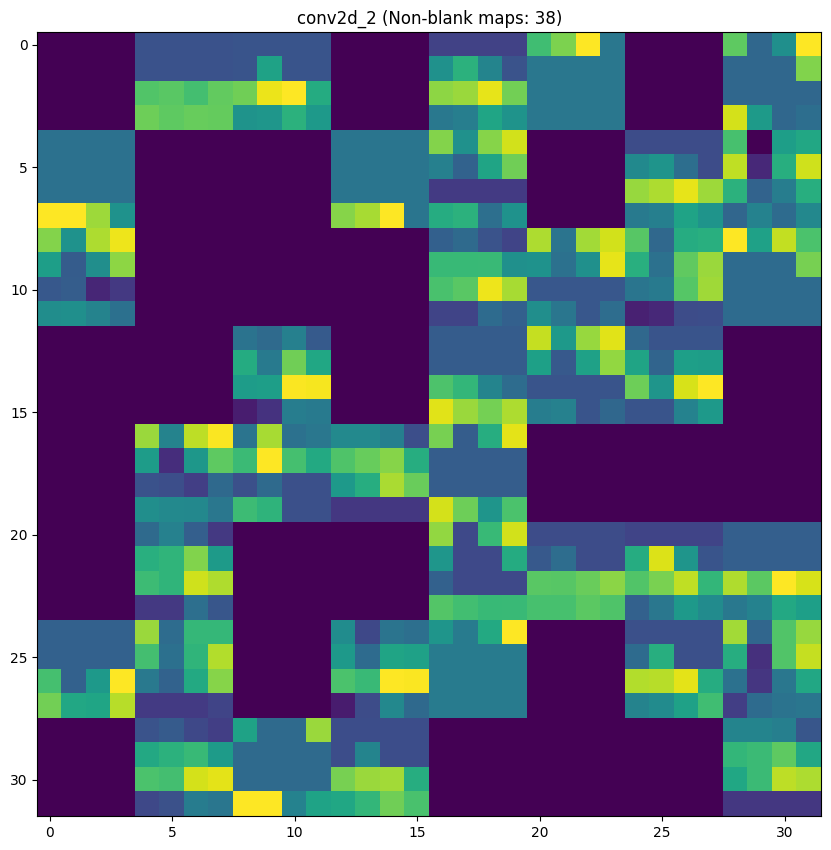

In [ ]:
visualize_activations(model, "conv2d_2", image, images_per_row=8)

In [ ]:
def analyze_neuron_influences(model, layer_name, threshold_pos=0.001, threshold_neg=-0.001):

  # Get the layer and weights
  layer = model.get_layer(layer_name)
  weights = layer.get_weights()[0]  # Assuming weights are at index 0
  print(weights.shape)
  # Analyze weights for each neuron
  for neuron_index in range(weights.shape[3]):
    neuron_weights = weights[:, :, :, neuron_index]
    #print(neuron_weights)
    # Calculate mean and standard deviation
    mean_weight = np.mean(neuron_weights)
    std_dev = np.std(neuron_weights)

    # Classify influence based on thresholds
    if mean_weight > threshold_pos:
      influence = "Positive (Potential)"
    elif mean_weight < threshold_neg:
      influence = "Negative (Potential)"
    else:
      influence = "Neutral"

    # Print information
    print(f"Layer: {layer_name}, Neuron: {neuron_index}")
    print(f"  Mean Weight: {mean_weight:.4f}")
    #print(f"  Standard Deviation: {std_dev:.4f}")
    print(f"  Influence: {influence}")
    print("")

# Analyze all neurons in a specific layer (replace layer name)
analyze_neuron_influences(model, 'conv2d_2')


(3, 3, 64, 64)
Layer: conv2d_2, Neuron: 0
  Mean Weight: -0.0054
  Influence: Negative (Potential)

Layer: conv2d_2, Neuron: 1
  Mean Weight: 0.0019
  Influence: Positive (Potential)

Layer: conv2d_2, Neuron: 2
  Mean Weight: 0.0123
  Influence: Positive (Potential)

Layer: conv2d_2, Neuron: 3
  Mean Weight: -0.0169
  Influence: Negative (Potential)

Layer: conv2d_2, Neuron: 4
  Mean Weight: 0.0237
  Influence: Positive (Potential)

Layer: conv2d_2, Neuron: 5
  Mean Weight: -0.0061
  Influence: Negative (Potential)

Layer: conv2d_2, Neuron: 6
  Mean Weight: -0.0047
  Influence: Negative (Potential)

Layer: conv2d_2, Neuron: 7
  Mean Weight: -0.0165
  Influence: Negative (Potential)

Layer: conv2d_2, Neuron: 8
  Mean Weight: -0.0143
  Influence: Negative (Potential)

Layer: conv2d_2, Neuron: 9
  Mean Weight: -0.0111
  Influence: Negative (Potential)

Layer: conv2d_2, Neuron: 10
  Mean Weight: -0.0154
  Influence: Negative (Potential)

Layer: conv2d_2, Neuron: 11
  Mean Weight: -0.0176
 

In [ ]:
def create_buckets(weights, num_buckets):

  # Calculate mean and standard deviation
  mean = np.mean(weights)
  std_dev = np.std(weights)

  # Define bucket boundaries with even spread
  bucket_width = 2 * std_dev / (num_buckets - 1)
  lower_bounds = [mean - i * bucket_width for i in range(num_buckets)]

  # Assign weights to buckets
  buckets = [[] for _ in range(num_buckets)]
  for i, weight in enumerate(weights):
    for j in range(num_buckets):
      if weight <= lower_bounds[j]:
        buckets[j].append(i)
        break  # Weight belongs to the first matching bucket

  return buckets

In [ ]:
def analyze_neuron_influences(model, layer_name, threshold_pos=0.001, threshold_neg=-0.001, num_buckets=3):

  # Get the layer and weights
  layer = model.get_layer(layer_name)
  weights = layer.get_weights()[0]  # Assuming weights are at index 0
  print(f"Weight shape: {weights.shape}")

  # Initialize influence dictionaries
  positive_influences, negative_influences, neutral_influences = [], [], []

  # Analyze weights for each neuron
  for neuron_index in range(weights.shape[3]):
    neuron_weights = weights[:, :, :, neuron_index]

    # Calculate mean and standard deviation
    mean_weight = np.mean(neuron_weights)
    std_dev = np.std(neuron_weights)

    # Classify influence based on thresholds
    influence_category = None
    if mean_weight > threshold_pos:
      influence_category = "positive"
    elif mean_weight < threshold_neg:
      influence_category = "negative"
    else:
      influence_category = "neutral"

    # Create influence entry with layer name and neuron number
    influence_entry = {
        "layer_name": layer_name,
        "neuron_number": neuron_index,
    }

    # Append influence entry to the appropriate list
    if influence_category:
      if influence_category == "positive":
        positive_influences.append(influence_entry)
      elif influence_category == "negative":
        negative_influences.append(influence_entry)
      else:
        neutral_influences.append(influence_entry)

  return {
      "positive": positive_influences,
      "negative": negative_influences,
      "neutral": neutral_influences,
  }

# Example usage (replace layer name and adjust thresholds/buckets if needed)
influence_map = analyze_neuron_influences(model, 'conv2d_1')
print(influence_map)


Weight shape: (3, 3, 32, 64)
{'positive': [{'layer_name': 'conv2d_1', 'neuron_number': 9}, {'layer_name': 'conv2d_1', 'neuron_number': 14}, {'layer_name': 'conv2d_1', 'neuron_number': 17}, {'layer_name': 'conv2d_1', 'neuron_number': 18}, {'layer_name': 'conv2d_1', 'neuron_number': 34}, {'layer_name': 'conv2d_1', 'neuron_number': 44}, {'layer_name': 'conv2d_1', 'neuron_number': 48}, {'layer_name': 'conv2d_1', 'neuron_number': 56}, {'layer_name': 'conv2d_1', 'neuron_number': 59}], 'negative': [{'layer_name': 'conv2d_1', 'neuron_number': 0}, {'layer_name': 'conv2d_1', 'neuron_number': 1}, {'layer_name': 'conv2d_1', 'neuron_number': 2}, {'layer_name': 'conv2d_1', 'neuron_number': 3}, {'layer_name': 'conv2d_1', 'neuron_number': 4}, {'layer_name': 'conv2d_1', 'neuron_number': 5}, {'layer_name': 'conv2d_1', 'neuron_number': 6}, {'layer_name': 'conv2d_1', 'neuron_number': 7}, {'layer_name': 'conv2d_1', 'neuron_number': 8}, {'layer_name': 'conv2d_1', 'neuron_number': 10}, {'layer_name': 'conv2d

In [ ]:
def analyze_neuron_influences_with_images(model, layer_name, test_images, threshold_pos=0.001, threshold_neg=-0.001, num_buckets=10):
  """
  Analyzes weights, categorizes neurons, and includes image data for visualization.

  Args:
      model: The Keras model to analyze.
      layer_name: The name of the convolutional layer to analyze (e.g., 'conv2d_1').
      test_images: A NumPy array of test images.
      threshold_pos: Threshold for considering a mean weight positive influence (default 0.001).
      threshold_neg: Threshold for considering a mean weight negative influence (default -0.001).
      num_buckets: The number of buckets to create for weight distribution analysis (default 10).

  Returns:
      A dictionary containing three lists for positive, negative, and neutral influences,
      each entry being a dictionary with 'layer_name', 'neuron_number', and 'image_data' keys.
  """

  # Get the layer and weights
  layer = model.get_layer(layer_name)
  weights = layer.get_weights()[0]  # Assuming weights are at index 0
  print(f"Weight shape: {weights.shape}")

  # Initialize influence dictionaries with image data
  positive_influences, negative_influences, neutral_influences = [], [], []

  # Analyze weights for each neuron
  for neuron_index in range(weights.shape[3]):
    neuron_weights = weights[:, :, :, neuron_index]

    # Calculate mean and standard deviation
    mean_weight = np.mean(neuron_weights)
    std_dev = np.std(neuron_weights)

    # Classify influence based on thresholds
    influence_category = None
    if mean_weight > threshold_pos:
      influence_category = "positive"
    elif mean_weight < threshold_neg:
      influence_category = "negative"
    else:
      influence_category = "neutral"

    # Create influence entry with layer name, neuron number, and image data
    influence_entry = {
        "layer_name": layer_name,
        "neuron_number": neuron_index,
        "image_data": None,  # Placeholder for image data
    }
    img_array = np.expand_dims(test_images[61], axis=0)
    influence_entry["image_data"] = img_array  # Assign pre-processed image data

    # Generate Class Activation Map (CAM)
    influence_entry["cam"] = make_gradcam_heatmap(img_array, model, layer_name)  # Modified line

    if influence_category == "positive":
      positive_influences.append(influence_entry)
    elif influence_category == "negative":
      negative_influences.append(influence_entry)
    else:
      neutral_influences.append(influence_entry)

  return {
      "positive": positive_influences,
      "negative": negative_influences,
      "neutral": neutral_influences,
  }


# Example usage (replace layer name and adjust thresholds/buckets if needed)
influence_map_with_images = analyze_neuron_influences_with_images(model, 'conv2d_1', test_images)
print(influence_map_with_images)


Weight shape: (3, 3, 32, 64)


InvalidArgumentError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:GPU:0}} required broadcastable shapes [Op:Mul] name: 

In [ ]:
!jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000.0  # Adjust limit as needed (bytes/sec)


|DEBUG|Paths used for configuration of jupyter_notebook_config: 
    	/etc/jupyter/jupyter_notebook_config.json
|DEBUG|Paths used for configuration of jupyter_notebook_config: 
    	/usr/local/etc/jupyter/jupyter_notebook_config.d/panel-client-jupyter.json
    	/usr/local/etc/jupyter/jupyter_notebook_config.json
|DEBUG|Paths used for configuration of jupyter_notebook_config: 
    	/usr/etc/jupyter/jupyter_notebook_config.json
|DEBUG|Paths used for configuration of jupyter_notebook_config: 
    	/root/.local/etc/jupyter/jupyter_notebook_config.json
|DEBUG|Paths used for configuration of jupyter_notebook_config: 
    	/root/.jupyter/jupyter_notebook_config.json

  _   _          _      _
 | | | |_ __  __| |__ _| |_ ___
 | |_| | '_ \/ _` / _` |  _/ -_)
  \___/| .__/\__,_\__,_|\__\___|
       |_|
                       
Read the migration plan to Notebook 7 to learn about the new features and the actions to take if you are using extensions.

https://jupyter-notebook.readthedocs.io/en/lates

In [18]:
def analyze_neuron_influences_with_images(model, layer_name, test_images, threshold_pos=0.001, threshold_neg=-0.001, num_buckets=10):
  """
  Analyzes weights, categorizes neurons, includes image data, and generates CAMs.

  Args:
      model: The Keras model to analyze.
      layer_name: The name of the convolutional layer to analyze (e.g., 'conv2d_1').
      test_images: A NumPy array of test images.
      threshold_pos: Threshold for considering a mean weight positive influence (default 0.001).
      threshold_neg: Threshold for considering a mean weight negative influence (default -0.001).
      num_buckets: The number of buckets to create for weight distribution analysis (default 10).

  Returns:
      A dictionary containing three lists for positive, negative, and neutral influences,
      each entry being a dictionary with 'layer_name', 'neuron_number', 'image_data', and 'cam' keys.
  """

  # Get the layer and weights
  layer = model.get_layer(layer_name)
  weights = layer.get_weights()[0]  # Assuming weights are at index 0
  print(f"Weight shape: {weights.shape}")

  # Initialize influence dictionaries with image data and CAM placeholders
  positive_influences, negative_influences, neutral_influences = [], [], []

  # Analyze weights for each neuron
  for neuron_index in range(weights.shape[3]):
    neuron_weights = weights[:, :, :, neuron_index]

    # Calculate mean and standard deviation
    mean_weight = np.mean(neuron_weights)
    std_dev = np.std(neuron_weights)

    # Classify influence based on thresholds
    influence_category = None
    if mean_weight > threshold_pos:
      influence_category = "positive"
    elif mean_weight < threshold_neg:
      influence_category = "negative"
    else:
      influence_category = "neutral"

    # Create influence entry with layer name, neuron number, image data, and CAM placeholder
    influence_entry = {
        "layer_name": layer_name,
        "neuron_number": neuron_index,
        "image_data": None,
        "cam": None,
    }

    # Append influence entry to the appropriate list
    if influence_category:
      # Pre-process image for the model (replace with your pre-processing steps)
      img_array = np.expand_dims(test_images[61], axis=0)  # Assuming test image at index 61

      influence_entry["image_data"] = img_array  # Assign pre-processed image data

      # Generate Class Activation Map (CAM)
      influence_entry["cam"] = make_gradcam_heatmap(img_array, model, layer_name)  # Modified line

      if influence_category == "positive":
        positive_influences.append(influence_entry)
      elif influence_category == "negative":
        negative_influences.append(influence_entry)
      else:
        neutral_influences.append(influence_entry)

  return {
      "positive": positive_influences,
      "negative": negative_influences,
      "neutral": neutral_influences,
  }
influence_map_with_images = analyze_neuron_influences_with_images(model, 'conv2d_1', test_images)
print(influence_map_with_images)

Weight shape: (3, 3, 32, 64)


ValueError: The layer sequential has never been called and thus has no defined output.

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.get_layer('global_average_pooling2d').output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        num_neurons = preds.shape[1]

    heatmaps = []
    for class_index in range(num_neurons):

        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = grad_model(img_array)
            class_channel = preds[:, class_index]
        grads = tape.gradient(class_channel, last_conv_layer_output)


        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))


        heatmap = tf.reduce_sum(last_conv_layer_output[0] * pooled_grads, axis=-1)
        heatmaps.append(heatmap)

    return heatmaps

In [ ]:
import cv2
import numpy as np

# last_layer = 'global_average_pooling2d'  # Choose the last convolutional layer

img_array = test_images[61]
img_array = np.expand_dims(img_array, axis=0)
print(img_array.shape)

# Remove last layer's softmax
#model.layers[-1].activation = None
preds = model.predict(img_array)
print("Predicted:", preds)
# Get the class activation map (CAM) for the image
heatmap = make_gradcam_heatmap( img_array,model, last_layer, 1)
print(heatmap)
plt.matshow(heatmap , cmap= "gray")
plt.show()
upscaled_heatmap = cv2.resize(heatmap, dsize=(32,32), interpolation=cv2.INTER_CUBIC)
plt.matshow(upscaled_heatmap, cmap= "gray")
plt.show()

In [ ]:
import cv2
import numpy as np

last_layer = 'global_average_pooling2d'  # Choose the last convolutional layer

img_array = test_images[61]
img_array = np.expand_dims(img_array, axis=0)
print(img_array.shape)

# Remove last layer's softmax
#model.layers[-1].activation = None
preds = model.predict(img_array)
print("Predicted:", preds)
# Get the class activation map (CAM) for the image
heatmap = grad_cam_single_neuron(model, img_array, last_layer, 1)
print(heatmap.shape)
plt.matshow(heatmap)
plt.show()
upscaled_heatmap = cv2.resize(heatmap, dsize=(32,32), interpolation=cv2.INTER_CUBIC)
plt.matshow(upscaled_heatmap)
plt.show()


In [ ]:
# Resize the heatmap to the size of the original image
heatmap_resized = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))

# Normalize the heatmap
heatmap_normalized = np.uint8(255 * heatmap_resized)

# Apply colormap
heatmap_colormap = cv2.applyColorMap(heatmap_normalized, cv2.COLORMAP_JET)
plt.matshow(heatmap_colormap)
plt.show()
# Convert img_array[0] to the same data type as heatmap
img_array_uint8 = np.uint8(img_array[0])

# Superimpose the heatmap on the original image
superimposed_img = cv2.addWeighted(img_array_uint8, 0.6, heatmap_colormap, 0.4, 0)
# Display the image
plt.matshow(superimposed_img)
plt.show()